In [2]:
import cgmquantify as cgm
import pandas as pd
import datetime as datetime
from datetime import date
from scipy.stats import stats
import numpy as np
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from scipy.signal import find_peaks
from scipy.stats import stats

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install cgmquantify

In [ ]:
!pip install tslearn

In [ ]:
!pip install imbalanced-learn

In [42]:
df_merged_all = pd.read_csv('df_overnight_and_PRO.csv', sep='\t')


In [43]:
df_merged_all

,Unnamed: 0,id,time,gl,phase,label,axis1,axis2,axis3,steps,lux,inclineOff,inclineStanding,inclineSitting,inclineLying,vm,joinID
0,0,1,2020-06-23 12:38:00+00:00,125.0,screening,Undefined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2020-06-23 12:45:00+00:00,120.0,screening,Undefined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,2020-06-23 12:45:00+00:00,121.0,screening,Undefined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,2020-06-23 12:53:00+00:00,114.0,screening,Undefined,705.0,593.0,1321.0,8.0,0.0,0.0,60.0,0.0,0.0,1611.0,NaN
4,4,1,2020-06-23 13:09:00+00:00,107.0,screening,Undefined,363.0,266.0,578.0,16.0,0.0,0.0,0.0,1.0,59.0,733.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112974,112974,47,2021-12-07 07:06:00+00:00,108.0,lTRE,Undefined,5565.0,5930.0,5865.0,36.0,0.0,0.0,60.0,0.0,0.0,10027.0,NaN
112975,112975,47,2021-12-07 07:21:00+00:00,110.0,lTRE,Undefined,2043.0,2564.0,3787.0,15.0,0.0,0.0,60.0,0.0,0.0,5009.0,NaN
112976,112976,47,2021-12-07 07:36:00+00:00,110.0,lTRE,Undefined,NaN,171.0,112.0,0.0,0.0,0.0,15.0,45.0,0.0,205.0,47.lTRE.2021-12-07
112977,112977,47,2021-12-07 07:51:00+00:00,109.0,lTRE,Undefined,4.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,60.0,4.0,NaN


In [44]:
df_merged_all = df_merged_all.dropna(subset=['axis1', 'axis2', 'axis3'],how='all')

df_merged_all['axis1'] = df_merged_all['axis1'].fillna(0)
df_merged_all['axis2'] = df_merged_all['axis2'].fillna(0)
df_merged_all['axis3'] = df_merged_all['axis3'].fillna(0)

df_merged_all['time'] = pd.to_datetime(df_merged_all['time'] ,errors = 'coerce')

df_merged_all = df_merged_all.reset_index(drop=True)
df_merged_all = df_merged_all.drop(["Unnamed: 0", "joinID"], axis=1)

fasting_states_to_keep = ['fasting', 'non-fasting']
df_merged_all = df_merged_all[df_merged_all.label.isin(fasting_states_to_keep)]

#phases_to_keep = ['lTRE', 'eTRE']
#df_merged_all = df_merged_all[df_merged_all.phase.isin(phases_to_keep)]

final_df = df_merged_all.sort_values(by=['id', 'time', "phase"], ascending=True)

In [45]:
final_df = final_df.reset_index(drop=True)

## Label Encoding

In [47]:
map_dict = {"non-fasting": 1, "fasting":0}
df_train["label"] = df_train["label"].map(map_dict)
df_test["label"] = df_test["label"].map(map_dict)

In [48]:
map_dict = {"screening": 1, "lTRE":0, "eTRE":2}
df_train["phase"] = df_train["phase"].map(map_dict)
df_test["phase"] = df_test["phase"].map(map_dict)

In [49]:
df_train

,id,time,gl,phase,label,axis1,axis2,axis3,steps,lux,inclineOff,inclineStanding,inclineSitting,inclineLying,vm
8203,10,2020-08-11 23:13:00+00:00,81.0,1,0,336.0,187.0,264.0,4.0,0.0,0.0,0.0,39.0,21.0,467.0
8204,10,2020-08-11 23:28:00+00:00,76.0,1,0,0.0,0.0,83.0,0.0,0.0,0.0,0.0,52.0,8.0,83.0
8205,10,2020-08-11 23:43:00+00:00,72.0,1,0,652.0,1028.0,897.0,3.0,0.0,0.0,60.0,0.0,0.0,1513.0
8206,10,2020-08-12 00:13:00+00:00,71.0,1,0,0.0,51.0,166.0,0.0,0.0,0.0,0.0,0.0,60.0,174.0
8207,10,2020-08-12 00:43:00+00:00,63.0,1,0,253.0,821.0,559.0,3.0,0.0,0.0,0.0,9.0,51.0,1025.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59922,47,2021-12-07 02:21:00+00:00,108.0,0,0,421.0,466.0,296.0,5.0,0.0,0.0,60.0,0.0,0.0,695.0
59923,47,2021-12-07 02:51:00+00:00,112.0,0,0,180.0,716.0,255.0,2.0,0.0,40.0,0.0,0.0,20.0,782.0
59924,47,2021-12-07 03:21:00+00:00,103.0,0,0,740.0,521.0,251.0,1.0,0.0,0.0,60.0,0.0,0.0,940.0
59925,47,2021-12-07 03:36:00+00:00,102.0,0,0,486.0,536.0,260.0,2.0,0.0,0.0,60.0,0.0,0.0,769.0


## Saving and Loading the featured Data

In [50]:
train_labels = df_train["label"]
test_labels = df_test["label"]

In [51]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [52]:
y_train_float = y_train
y_test_float = y_test

In [12]:
mylist = list(set(y_train_float))
mylist

[0, 1]

## Building the time series

### Test-dataset

In [53]:
X_test = df_test

### acc and gl

In [15]:
from datetime import datetime


X_test.time = pd.to_datetime(X_test.time)

x_list_test_tsc_1st = []
test_labels_tsc = []
x_list_test_tsc_2nd = []
counter=0


last_time_before = X_test['time'].values[0]

for i in range(0, X_test.shape[0], 1):
    time = X_test['time'].values[i]
    gl =  X_test['gl'].values[i]
    axis1 = X_test['axis1'].values[i]
    axis2 = X_test['axis2'].values[i]
    axis3 = X_test['axis3'].values[i]
    steps = X_test['steps'].values[i]
    lux = X_test['lux'].values[i]
    inclineStanding = X_test['inclineStanding'].values[i]
    inclineSitting = X_test['inclineSitting'].values[i]
    inclineLying = X_test['inclineLying'].values[i]
    vm = X_test['vm'].values[i]

    timedelta_first =  time - last_time_before

    one_hour = 3600000000000
    
    if timedelta_first < one_hour and counter < 5:
        x_list_test_tsc_3rd = []
        x_list_test_tsc_3rd.append(gl)
        x_list_test_tsc_3rd.append(axis1)
        x_list_test_tsc_3rd.append(axis2)
        x_list_test_tsc_3rd.append(axis3)
        x_list_test_tsc_3rd.append(steps)
        x_list_test_tsc_3rd.append(lux)
        x_list_test_tsc_3rd.append(inclineStanding)
        x_list_test_tsc_3rd.append(inclineSitting)
        x_list_test_tsc_3rd.append(inclineLying)
        x_list_test_tsc_3rd.append(vm)

        x_list_test_tsc_2nd.append(x_list_test_tsc_3rd)
    
    else:
        
        if counter == 5:
            x_list_test_tsc_1st.append(x_list_test_tsc_2nd)
            test_labels_tsc.append(y_test_float[i])
            
        counter = 0
        x_list_test_tsc_2nd = [] 
        x_list_test_tsc_3rd = []
        x_list_test_tsc_3rd.append(gl)
        x_list_test_tsc_3rd.append(axis1)
        x_list_test_tsc_3rd.append(axis2)
        x_list_test_tsc_3rd.append(axis3)
        x_list_test_tsc_3rd.append(steps)
        x_list_test_tsc_3rd.append(lux)
        x_list_test_tsc_3rd.append(inclineStanding)
        x_list_test_tsc_3rd.append(inclineSitting)
        x_list_test_tsc_3rd.append(inclineLying)
        x_list_test_tsc_3rd.append(vm)
        x_list_test_tsc_2nd.append(x_list_test_tsc_3rd)
        
    counter += 1
    
    last_time_before = time


### gl

In [14]:
from datetime import datetime


X_test.time = pd.to_datetime(X_test.time)

x_list_test_tsc_1st = []
test_labels_tsc = []
x_list_test_tsc_2nd = []
counter=0


last_time_before = X_test['time'].values[0]

for i in range(0, X_test.shape[0], 1):
    time = X_test['time'].values[i]
    gl =  X_test['gl'].values[i]

    
    timedelta_first =  time - last_time_before

    one_hour = 3600000000000
    
    if timedelta_first < one_hour and counter < 5:
        x_list_test_tsc_3rd = []
        x_list_test_tsc_3rd.append(gl)

        x_list_test_tsc_2nd.append(x_list_test_tsc_3rd)
    
    else:
        
        if counter == 5:
            x_list_test_tsc_1st.append(x_list_test_tsc_2nd)
            test_labels_tsc.append(y_test_float[i])
            
        counter = 0
        x_list_test_tsc_2nd = [] 
        x_list_test_tsc_3rd = []
        x_list_test_tsc_3rd.append(gl)
        x_list_test_tsc_2nd.append(x_list_test_tsc_3rd)
        
    counter += 1
    
    last_time_before = time

### acc

In [54]:
from datetime import datetime


X_test.time = pd.to_datetime(X_test.time)

x_list_test_tsc_1st = []
test_labels_tsc = []
x_list_test_tsc_2nd = []
counter=0


last_time_before = X_test['time'].values[0]

for i in range(0, X_test.shape[0], 1):
    time = X_test['time'].values[i]
    axis1 = X_test['axis1'].values[i]
    axis2 = X_test['axis2'].values[i]
    axis3 = X_test['axis3'].values[i]
    steps = X_test['steps'].values[i]
    lux = X_test['lux'].values[i]
    inclineStanding = X_test['inclineStanding'].values[i]
    inclineSitting = X_test['inclineSitting'].values[i]
    inclineLying = X_test['inclineLying'].values[i]
    vm = X_test['vm'].values[i]
    
    timedelta_first =  time - last_time_before

    one_hour = 3600000000000
    
    if timedelta_first < one_hour and counter < 5:
        x_list_test_tsc_3rd = []

        x_list_test_tsc_3rd.append(axis1)
        x_list_test_tsc_3rd.append(axis2)
        x_list_test_tsc_3rd.append(axis3)
        x_list_test_tsc_3rd.append(steps)
        x_list_test_tsc_3rd.append(lux)
        x_list_test_tsc_3rd.append(inclineStanding)
        x_list_test_tsc_3rd.append(inclineSitting)
        x_list_test_tsc_3rd.append(inclineLying)
        x_list_test_tsc_3rd.append(vm)
        x_list_test_tsc_2nd.append(x_list_test_tsc_3rd)
    
    else:
        
        if counter == 5:
            x_list_test_tsc_1st.append(x_list_test_tsc_2nd)
            test_labels_tsc.append(y_test_float[i])
            
        counter = 0
        x_list_test_tsc_2nd = [] 
        x_list_test_tsc_3rd = []

        x_list_test_tsc_3rd.append(axis1)
        x_list_test_tsc_3rd.append(axis2)
        x_list_test_tsc_3rd.append(axis3)
        x_list_test_tsc_3rd.append(steps)
        x_list_test_tsc_3rd.append(lux)
        x_list_test_tsc_3rd.append(inclineStanding)
        x_list_test_tsc_3rd.append(inclineSitting)
        x_list_test_tsc_3rd.append(inclineLying)
        x_list_test_tsc_3rd.append(vm)
        x_list_test_tsc_2nd.append(x_list_test_tsc_3rd)
        
    counter += 1
    
    last_time_before = time

### Train-Dataset

In [55]:
X_train = df_train

In [17]:
from datetime import datetime


X_train.time = pd.to_datetime(X_train.time)


x_list_train_tsc_1st = []
train_labels_tsc = []
x_list_train_tsc_2nd = []
counter = 0


last_time_before = X_train['time'].values[0]



for i in range(0, X_train.shape[0], 1):
    time = X_train['time'].values[i]
    gl =  X_train['gl'].values[i]
    axis1 = X_train['axis1'].values[i]
    axis2 = X_train['axis2'].values[i]
    axis3 = X_train['axis3'].values[i]
    steps = X_train['steps'].values[i]
    lux = X_train['lux'].values[i]
    inclineStanding = X_train['inclineStanding'].values[i]
    inclineSitting = X_train['inclineSitting'].values[i]
    inclineLying = X_train['inclineLying'].values[i]
    vm = X_train['vm'].values[i]
    
    timedelta_first =  time - last_time_before

    one_hour = 3600000000000
    
    if timedelta_first < one_hour and counter < 5:
        
        x_list_train_tsc_3rd = []
        x_list_train_tsc_3rd.append(gl)
        x_list_train_tsc_3rd.append(axis1)
        x_list_train_tsc_3rd.append(axis2)
        x_list_train_tsc_3rd.append(axis3)
        x_list_train_tsc_3rd.append(steps)
        x_list_train_tsc_3rd.append(lux)
        x_list_train_tsc_3rd.append(inclineStanding)
        x_list_train_tsc_3rd.append(inclineSitting)
        x_list_train_tsc_3rd.append(inclineLying)
        x_list_train_tsc_3rd.append(vm)
        x_list_train_tsc_2nd.append(x_list_train_tsc_3rd)
    
    else:
        if counter == 5:
            x_list_train_tsc_1st.append(x_list_train_tsc_2nd)
            train_labels_tsc.append(y_train_float[i])
            
        counter = 0
        x_list_train_tsc_2nd = [] 
        x_list_train_tsc_3rd = []
        x_list_train_tsc_3rd.append(gl)
        x_list_train_tsc_3rd.append(axis1)
        x_list_train_tsc_3rd.append(axis2)
        x_list_train_tsc_3rd.append(axis3)
        x_list_train_tsc_3rd.append(steps)
        x_list_train_tsc_3rd.append(lux)
        x_list_train_tsc_3rd.append(inclineStanding)
        x_list_train_tsc_3rd.append(inclineSitting)
        x_list_train_tsc_3rd.append(inclineLying)
        x_list_train_tsc_3rd.append(vm)
        x_list_train_tsc_2nd.append(x_list_train_tsc_3rd)
    counter += 1
    last_time_before = time

### gl

In [17]:
from datetime import datetime


X_train.time = pd.to_datetime(X_train.time)


x_list_train_tsc_1st = []
train_labels_tsc = []
x_list_train_tsc_2nd = []
counter = 0


last_time_before = X_train['time'].values[0]



for i in range(0, X_train.shape[0], 1):
    time = X_train['time'].values[i]
    gl =  X_train['gl'].values[i]
    timedelta_first =  time - last_time_before

    one_hour = 3600000000000
    
    if timedelta_first < one_hour and counter < 5:
        
        x_list_train_tsc_3rd = []
        x_list_train_tsc_3rd.append(gl)

        x_list_train_tsc_2nd.append(x_list_train_tsc_3rd)
    
    else:
        if counter == 5:
            x_list_train_tsc_1st.append(x_list_train_tsc_2nd)
            train_labels_tsc.append(y_train_float[i])
            
        counter = 0
        x_list_train_tsc_2nd = [] 
        x_list_train_tsc_3rd = []
        x_list_train_tsc_3rd.append(gl)

        x_list_train_tsc_2nd.append(x_list_train_tsc_3rd)
    counter += 1
    last_time_before = time

### acc

In [56]:
from datetime import datetime


X_train.time = pd.to_datetime(X_train.time)


x_list_train_tsc_1st = []
train_labels_tsc = []
x_list_train_tsc_2nd = []
counter = 0


last_time_before = X_train['time'].values[0]



for i in range(0, X_train.shape[0], 1):
    time = X_train['time'].values[i]
    axis1 = X_train['axis1'].values[i]
    axis2 = X_train['axis2'].values[i]
    axis3 = X_train['axis3'].values[i]
    steps = X_train['steps'].values[i]
    lux = X_train['lux'].values[i]
    inclineStanding = X_train['inclineStanding'].values[i]
    inclineSitting = X_train['inclineSitting'].values[i]
    inclineLying = X_train['inclineLying'].values[i]
    vm = X_train['vm'].values[i]
    
    timedelta_first =  time - last_time_before

    one_hour = 3600000000000
    
    if timedelta_first < one_hour and counter < 5:
        
        x_list_train_tsc_3rd = []
        x_list_train_tsc_3rd.append(axis1)
        x_list_train_tsc_3rd.append(axis2)
        x_list_train_tsc_3rd.append(axis3)
        x_list_train_tsc_3rd.append(steps)
        x_list_train_tsc_3rd.append(lux)
        x_list_train_tsc_3rd.append(inclineStanding)
        x_list_train_tsc_3rd.append(inclineSitting)
        x_list_train_tsc_3rd.append(inclineLying)
        x_list_train_tsc_3rd.append(vm)
        x_list_train_tsc_2nd.append(x_list_train_tsc_3rd)
    
    else:
        if counter == 5:
            x_list_train_tsc_1st.append(x_list_train_tsc_2nd)
            train_labels_tsc.append(y_train_float[i])
            
        counter = 0
        x_list_train_tsc_2nd = [] 
        x_list_train_tsc_3rd = []
        x_list_train_tsc_3rd.append(axis1)
        x_list_train_tsc_3rd.append(axis2)
        x_list_train_tsc_3rd.append(axis3)
        x_list_train_tsc_3rd.append(steps)
        x_list_train_tsc_3rd.append(lux)
        x_list_train_tsc_3rd.append(inclineStanding)
        x_list_train_tsc_3rd.append(inclineSitting)
        x_list_train_tsc_3rd.append(inclineLying)
        x_list_train_tsc_3rd.append(vm)
        
        x_list_train_tsc_2nd.append(x_list_train_tsc_3rd)
    counter += 1
    last_time_before = time

# TS Learn Classification

### To Time Series Dataset

In [57]:
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn import generators


In [58]:
X_train =to_time_series_dataset(x_list_train_tsc_1st)
X_test =to_time_series_dataset(x_list_test_tsc_1st)

In [59]:
y_train =  np.array(train_labels_tsc)
y_test =  np.array(test_labels_tsc)

### Checking for Balance

In [60]:
from collections import Counter
print(Counter(y_test).keys()) # equals to list(set(words))
print(Counter(y_test).values()) # counts the elements' frequency
print(Counter(y_train).keys()) # equals to list(set(words))
print(Counter(y_train).values()) # counts the elements' frequency

dict_keys([1, 0])
dict_values([1148, 319])
dict_keys([0, 1])
dict_values([2410, 7146])


In [61]:
data2d_test = X_test.reshape(X_test.shape[0], -1)
data2d_train = X_train.reshape(X_train.shape[0], -1)

In [62]:
print(X_test.shape)
print(X_train.shape)
print(data2d_test.shape)
print(data2d_train.shape)

(1467, 5, 9)
(9556, 5, 9)
(1467, 45)
(9556, 45)


### Undersampling with Random Selection

In [63]:
from imblearn.under_sampling import RandomUnderSampler
import collections
rus = RandomUnderSampler(random_state=0, replacement=True)
data2d_test_resampled , y_test_resampled = rus.fit_resample(data2d_test, y_test)
data2d_train_resampled , y_train_resampled = rus.fit_resample(data2d_train, y_train)

In [64]:
print(data2d_test_resampled.shape)
print(data2d_train_resampled.shape)

(638, 45)
(4820, 45)


In [65]:
from collections import Counter
print(Counter(y_test_resampled).keys()) # equals to list(set(words))
print(Counter(y_test_resampled).values()) # counts the elements' frequency
print(Counter(y_train_resampled).keys()) # equals to list(set(words))
print(Counter(y_train_resampled).values()) # counts the elements' frequency

dict_keys([0, 1])
dict_values([319, 319])
dict_keys([0, 1])
dict_values([2410, 2410])


In [66]:
data2d_test_resampled.shape[0]

638

In [67]:
scaler = MinMaxScaler()
scaler.fit(data2d_train_resampled)
data2d_train_resampled = scaler.transform(data2d_train_resampled)
data2d_test_resampled = scaler.transform(data2d_test_resampled)

In [68]:
data3d_X_test = data2d_test_resampled.reshape(-1, X_test.shape[1], X_test.shape[2])
data3d_X_train = data2d_train_resampled.reshape(-1, X_train.shape[1], X_train.shape[2])

In [69]:
print(data3d_X_test.shape)
print(data3d_X_train.shape)

(638, 5, 9)
(4820, 5, 9)


In [31]:
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    '''Display grid search results

    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

In [31]:
from numpy.lib.stride_tricks import sliding_window_view


def smoothing(y_pred):
    
    outcomes = np.array([])
    last_four_values = y_pred[-4:]
    
    y_pred_windowed = sliding_window_view((y_pred), window_shape = 5)

    i = 0
    for window in y_pred_windowed:
        pred_one = np.count_nonzero(window == 1)
        pred_zero = 5 - pred_one
        if pred_one > pred_zero:
            outcome = int(1)
            outcomes = np.append(outcomes, outcome)
        else:
            outcome = int(0)
            outcomes = np.append(outcomes, outcome)
    
    outcomes = np.append(outcomes, last_four_values)
            
    
    return outcomes

## KNeighborsTimeSeriesClassifier

In [32]:
from sklearn.model_selection import RandomizedSearchCV


In [70]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
knn = KNeighborsTimeSeriesClassifier(n_neighbors=93)
knn.fit(data3d_X_train, y_train_resampled)

KNeighborsTimeSeriesClassifier(n_neighbors=93)

In [71]:
y_pred = knn.predict(data3d_X_test)

In [73]:
print("Accuracy:", accuracy_score(y_test_resampled,smoothing(y_pred)))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test_resampled, y_pred))

Accuracy: 0.7601880877742947

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.63      0.76      0.69       319
           1       0.70      0.55      0.61       319

    accuracy                           0.66       638
   macro avg       0.66      0.66      0.65       638
weighted avg       0.66      0.66      0.65       638



In [30]:
# set search parameters
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)]   
weights = ['uniform','distance']
metric = ['euclidean','manhattan','chebyshev','minkowski'] 
random_grid = {
    'n_neighbors': n_neighbors,
    'weights': weights,
    'metric': metric,
}

In [31]:
from sklearn.model_selection import RandomizedSearchCV
knn_random = RandomizedSearchCV(estimator = knn, random_state = 42,n_jobs = -1,param_distributions = random_grid,n_iter = 100, cv=3,verbose = 2)
knn_random.fit(data3d_X_train, y_train_resampled)
knn_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'weights': 'distance', 'n_neighbors': 93, 'metric': 'euclidean'}

In [32]:
knn_random.best_params_

best_estimator = knn_random.best_estimator_

best_estimator.fit(data3d_X_train, y_train_resampled)

pred = best_estimator.predict(data3d_X_test)

accuracy_score(pred, y_test_resampled)

0.677115987460815

In [33]:
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test_resampled, pred))


 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.66      0.73      0.69       319
           1       0.70      0.63      0.66       319

    accuracy                           0.68       638
   macro avg       0.68      0.68      0.68       638
weighted avg       0.68      0.68      0.68       638



best parameters: {'weights': 'distance', 'n_neighbors': 93, 'metric': 'euclidean'}
best score:      0.78216 (+/-0.00994)
{'metric': 'euclidean',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 93,
 'verbose': 0,
 'weights': 'distance'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,param_n_neighbors,param_metric,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,0.302332,0.009177,0.445667,0.002868,distance,93,euclidean,"{'weights': 'distance', 'n_neighbors': 93, 'me...",0.795893,0.777847,0.772727,0.782156,0.009936,1
20,0.339667,0.009286,0.459001,0.002160,distance,77,euclidean,"{'weights': 'distance', 'n_neighbors': 77, 'me...",0.792159,0.782203,0.772105,0.782156,0.008187,2
99,0.293999,0.006482,0.254332,0.008654,distance,75,euclidean,"{'weights': 'distance', 'n_neighbors': 75, 'me...",0.789048,0.781581,0.771482,0.780703,0.007198,3
69,0.304665,0.007040,0.437333,0.001247,distance,73,euclidean,"{'weights': 'distance', 'n_neighbors': 73, 'me...",0.790292,0.782203,0.768991,0.780496,0.008780,4
33,0.305666,0.003091,0.435001,0.009416,distance,57,euclidean,"{'weights': 'distance', 'n_neighbors': 57, 'me...",0.787181,0.781581,0.770859,0.779874,0.006772,5
85,0.304998,0.006976,0.434000,0.005657,distance,63,euclidean,"{'weights': 'distance', 'n_neighbors': 63, 'me...",0.785937,0.780336,0.772105,0.779459,0.005681,6
43,0.308670,0.005793,0.435663,0.004191,distance,25,euclidean,"{'weights': 'distance', 'n_neighbors': 25, 'me...",0.772869,0.783447,0.776463,0.777593,0.004392,7
41,0.312666,0.005437,0.436000,0.006532,distance,55,euclidean,"{'weights': 'distance', 'n_neighbors': 55, 'me...",0.781581,0.781581,0.768991,0.777384,0.005935,8
2,0.758333,0.010872,0.408333,0.006600,distance,33,euclidean,"{'weights': 'distance', 'n_neighbors': 33, 'me...",0.774113,0.781581,0.773973,0.776555,0.003554,9
73,0.305999,0.007118,0.442001,0.003742,distance,45,euclidean,"{'weights': 'distance', 'n_neighbors': 45, 'me...",0.777225,0.779714,0.772105,0.776348,0.003168,10


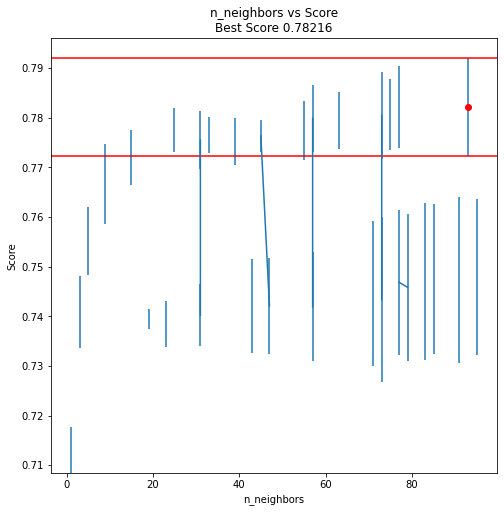

In [35]:
GridSearch_table_plot(knn_random, "n_neighbors", negative=False)

In [41]:
y_pred = knn.predict(data3d_X_test)
accuracy_score(y_test_resampled, y_pred)

0.647196261682243

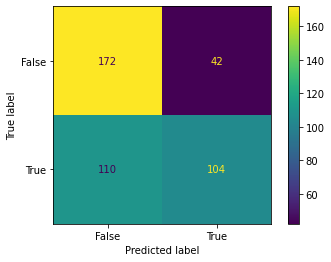

In [66]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test_resampled, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()


In [42]:
import pickle
with open('TSC_data/models_raw_TSC/gl/KNN_TSC_scaled.pkl','wb') as f:
    pickle.dump(knn,f)

## TimeSeriesSVC

In [40]:
import pickle
start = "models_raw_TSC\\"
end = ".pkl"
folder = "gl\\"
ml_type = "KNN_TSC"

path = start + folder + ml_type + end

with open(path, "rb") as f:
    model = pickle.load(f)

In [ ]:
from tslearn.svm import TimeSeriesSVC
clf = TimeSeriesSVC(C=1.0, kernel="gak")
clf.fit(data3d_X_train,y_train_resampled)

In [40]:
parameters = {'kernel': ['rbf', 'sigmoid'],
             'C': [1.0, 100.0, 1000.0],
             'gamma': [0.001, 0.01,0.1]}#


In [41]:
random_estimator = RandomizedSearchCV(estimator = clf,
                                   param_distributions = parameters,
                                   cv = 5,
                                   n_iter = 10,
                                   scoring = 'accuracy',
                                   n_jobs = -1,
                                   verbose = 1, 
                                   random_state = 1,
                                  )

random_estimator.fit(data3d_X_train, y_train_resampled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=TimeSeriesSVC(), n_jobs=-1,
                   param_distributions={'C': [1.0, 100.0, 1000.0],
                                        'gamma': [0.001, 0.01, 0.1],
                                        'kernel': ['rbf', 'sigmoid']},
                   random_state=1, scoring='accuracy', verbose=1)

In [42]:
random_estimator.best_params_

{'kernel': 'sigmoid', 'gamma': 0.001, 'C': 1000.0}

In [54]:
random_estimator.best_params_

best_estimator = random_estimator.best_estimator_

best_estimator.fit(data3d_X_train, y_train_resampled)

pred = best_estimator.predict(data3d_X_test)

accuracy_score(pred, smoothing(y_test_resampled))

0.7445141065830722

In [41]:
pred = model.predict(data3d_X_test)

accuracy_score(y_test_resampled, smoothing(pred))

0.5

In [44]:
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test_resampled, pred))


 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       319
           1       0.75      0.74      0.75       319

    accuracy                           0.75       638
   macro avg       0.75      0.75      0.75       638
weighted avg       0.75      0.75      0.75       638



In [ ]:
y_pred = clf.predict(data3d_X_test)
accuracy_score(y_test_resampled, smoothing(y_pred))

In [ ]:
parameters = {'kernel': ['rbf', 'sigmoid', 'poly'],
             'C': [0.1, 1.0, 100.0, 1000.0],
             'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0],}#


In [ ]:
random_estimator = RandomizedSearchCV(estimator = clf,
                                   param_distributions = parameters,
                                   cv = 5,
                                   n_iter = 100,
                                   scoring = 'accuracy',
                                   n_jobs = -1,
                                   verbose = 1, 
                                   random_state = 1,
                                  )

random_estimator.fit(data3d_X_train, y_train_resampled)

In [ ]:
random_estimator.best_params_

best_estimator = random_estimator.best_estimator_

best_estimator.fit(X_train_data_lr, y_train_resampled)

pred = best_estimator.predict(X_test_data_lr)

accuracy_score(pred, y_test_resampled)

In [ ]:
GridSearch_table_plot(random_estimator, "gamma", negative=False)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test_resampled, pred))

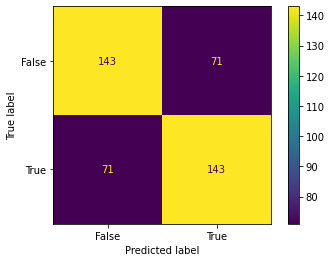

In [70]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test_resampled, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()


In [71]:
import pickle
with open('TSC_data/models_raw_TSC/gl/CLF_TSC.pkl','wb') as f:
    pickle.dump(clf,f)

In [36]:
print("d")

d


## Clustering TimeSeriesKMeans

In [91]:
from tslearn.clustering import TimeSeriesKMeans
km = TimeSeriesKMeans(n_clusters=2, metric="dtw")
labels = km.fit_predict(data3d_X_train)


km_bis = TimeSeriesKMeans(n_clusters=2, metric="softdtw")
labels_bis = km_bis.fit_predict(data3d_X_train)

In [86]:
pred_df = pd.DataFrame({"actual":y_train_resampled, "prediction":labels})

In [92]:
correct = 0
for i in range(len(y_train_resampled)):
    if labels_bis[i] == y_train_resampled[i]:
        correct += 1

print(correct/len(y_train_resampled))

0.363855421686747


## Model Selection with hypterparameter tuning and KNeighborsTimeSeriesClassifier

In [94]:
from sklearn.model_selection import KFold, GridSearchCV
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier(metric="dtw")
p_grid = {"n_neighbors": [1, 5]}

cv = KFold(n_splits=2, shuffle=True, random_state=0)
clf = GridSearchCV(estimator=knn, param_grid=p_grid, cv=cv)
clf.fit(data3d_X_train, y_train_resampled)

GridSearchCV(cv=KFold(n_splits=2, random_state=0, shuffle=True),
             estimator=KNeighborsTimeSeriesClassifier(),
             param_grid={'n_neighbors': [1, 5]})